In [1]:
%load_ext autoreload
%autoreload 2

import re
import glob
import lzma
import pickle
import pandas as pd
import numpy as np
import requests as r
import seaborn as sns
import warnings
import matplotlib as mpl
import matplotlib.pyplot as plt
from joblib import hash
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import NearestCentroid
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import RidgeClassifier, RidgeClassifierCV, PassiveAggressiveClassifier

warnings.simplefilter('ignore')
mpl.style.use('ggplot')

## Source Data

IF source data is missing run Elasticsearch query to extract data and then save it in JSON format to `data` directory

In [2]:
# news_json = r.get('http://locslhost:9200/indice/doc/_search?sort=date:desc&size=4000').json()
# with open('./data/news.json', 'w', encoding='utf8') as fh:
#   dump(news_json['hits']['hits'], fh)

In [3]:
# df = pd.io.json.json_normalize(news_json['hits']['hits'])
# df.to_json('./data/news.json')

In [4]:
df = pd.read_json('./data/news.json')

## Common issues that we generally face during the data preparation phase:
 - Format and structure normalization
 - Detect and fix missing values
 - Duplicates removal
 - Units normalization
 - Constraints validations
 - Anomaly detection and removal
 - Study of features importance/relevance
 - Dimentional reduction, feature selection & extraction

In [5]:
df = df[['_source.body', '_source.date', '_source.subject', '_source.language', '_source.categories']]
df.columns = ['body', 'pubdate', 'subject', 'language', 'categories']

In [6]:
df.drop_duplicates(inplace=True)
df.head(1).T.style

,0
body,"Two years ago, the Poor People’s Campaign (which I co-chair alongside Reverend William Barber II) and the Institute for Policy Studies released an audit of America . Its centerpiece was a far more realistic assessment of poverty and economic precariousness in this country. Using the Census Bureau’s Supplemental Poverty Measure as a baseline, which, among other things, measures family income after taxes and out-of-pocket expenses for food, clothing, housing, and utilities, there are at least 140 million people who are poor — or just a $400 emergency from that state. (Of that, there are now untold examples in this pandemic moment.)"
pubdate,2020-04-23T08:56:45.000Z
subject,Inequality and the Coronavirus: How to Destroy American Society From the Top Down
language,English
categories,articles 2015


In [7]:
df = df.loc[(df['categories'] != 'News') & 
            (df['categories'] != 'articles 2015') & 
            (df['categories'] != 'frontpage') &
            (df['categories'] != 'English') &
            (df['categories'] != 'Comment') &
            (df['categories'] != 'Uncategorized') &
            (df['language'] == 'English')]

In [8]:
df['categories'] = df['categories'].str.replace(r'[^a-zA-Z_, ]+', '').replace(', ', '')
df['categories'] = df['categories'].str.replace(r'^, ', '')

In [9]:
df.groupby(['categories']).agg({'count'}).drop_duplicates()

,body,pubdate,subject,language
,count,count,count,count
categories,,,,
,1,1,1,1
"election, barack obama, bernie sanders",2,2,2,2
"Africa, African Union, Asia Americas",3,3,3,3
"Africa, Algeria, News",8,8,8,8
"Africa, Article, Asia Americas",4,4,4,4
"Africa, Egypt, Europe Russia",9,9,9,9
"Africa, Egypt, News",14,14,14,14
"Africa, ICC, International Organisations",5,5,5,5


In [10]:
df['cat_id']       = df['categories'].factorize()[0]
df['lang_id']      = df['language'].factorize()[0]
df['char_count']   = df['body'].apply(len)
df['word_count']   = df['body'].apply(lambda x: len(x.split()))
df['word_density'] = df['char_count'] / (df['word_count']+1)

In [11]:
df.shape

(2129, 10)

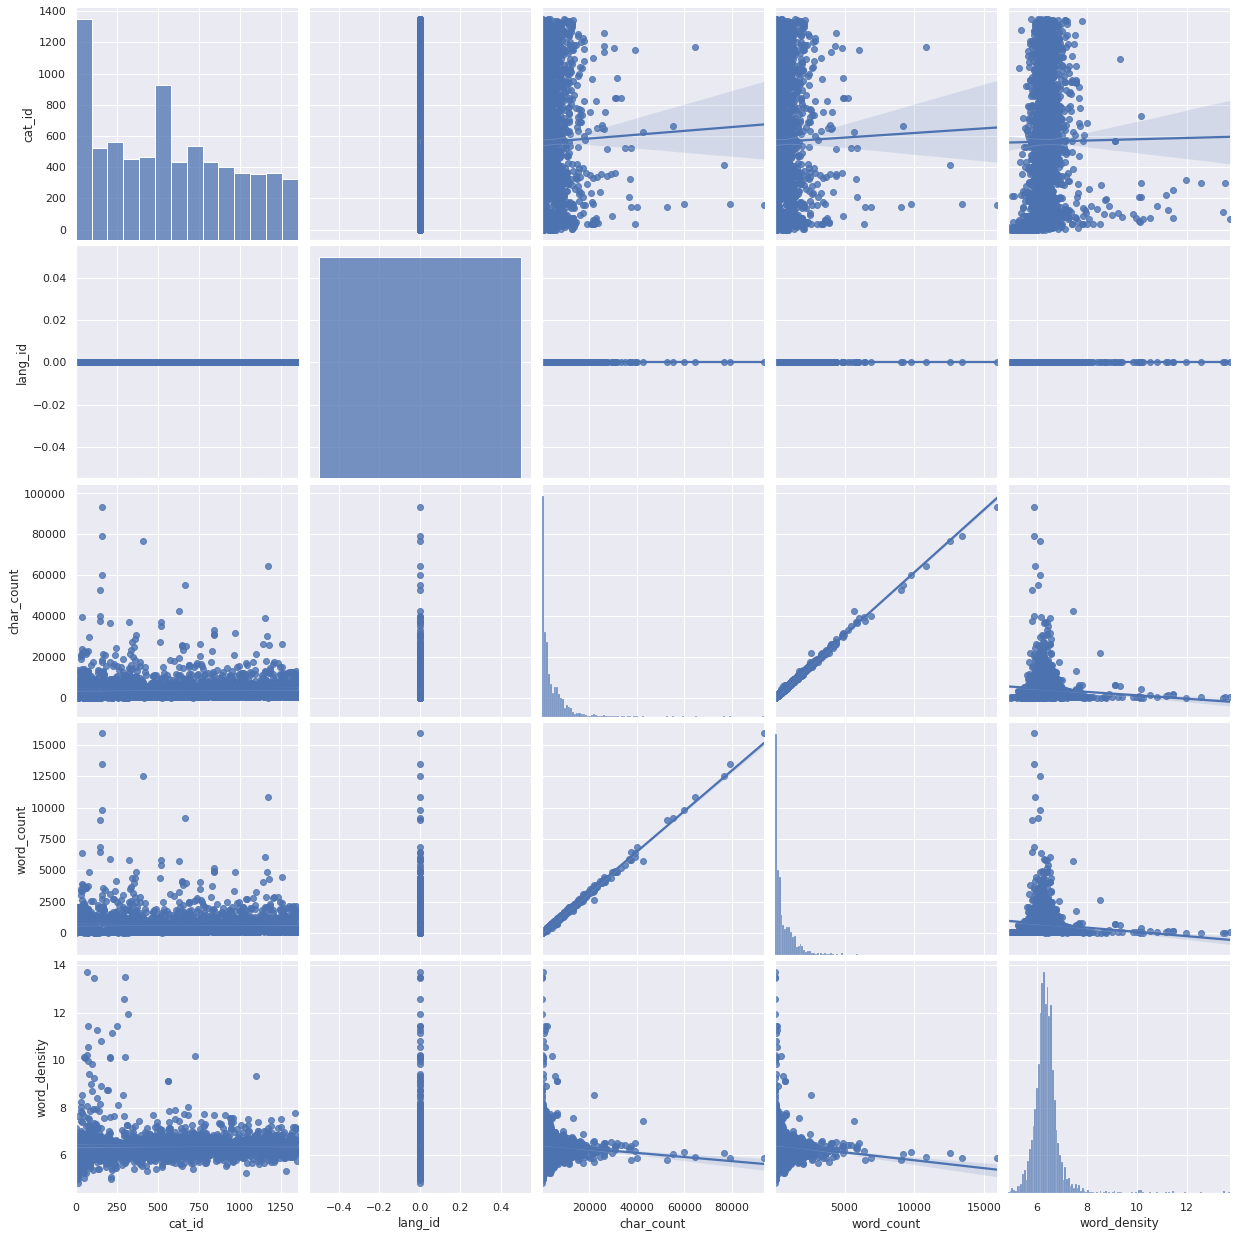

In [12]:
sns.set()
sns.pairplot(df, height=3.5, kind="reg", palette="husl", diag_kind="auto")

In [13]:

xtrain, xtest, ytrain, ytest = train_test_split(df['body'], df['categories'], test_size=0.2, random_state=42)


In [14]:

tfidf = TfidfVectorizer(use_idf=False, sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')


In [15]:
features = tfidf.fit_transform(df.body).toarray()
labels = df.cat_id

In [16]:
engines = [('PassiveAggressiveClassifier', PassiveAggressiveClassifier(fit_intercept=True, n_jobs=-1, random_state=0)),
           ('NearestCentroid', NearestCentroid()), 
           ('RandomForestClassifier', RandomForestClassifier(min_samples_leaf=0.01))]

In [17]:
for name, engine in engines:
  clf        = make_pipeline(tfidf, engine).fit(xtrain, ytrain)
  prediction = clf.predict(xtest)
  score      = clf.score(xtest, prediction)
  with lzma.open('./data/{}.pickle.xz'.format(name.lower()), 'wb') as f:
    pickle.dump(clf, f, protocol=5)

In [18]:
s = '''

‘Guys, you’ve got to hear this,” I said. I was sitting in front of my computer one day in July 2012, with one eye on a screen of share prices and the other on a live stream of the House of Commons Treasury select committee hearings. As the Barclays share price took a graceful swan dive, I pulled my headphones out of the socket and turned up the volume so everyone could hear. My colleagues left their terminals and came around to watch BBC Parliament with me.

It didn’t take long to realise what was happening. “Bob’s getting murdered,” someone said.

Bob Diamond, the swashbuckling chief executive of Barclays, had been called before the committee to explain exactly what his bank had been playing at in regards to the Libor rate-fixing scandal. The day before his appearance, he had made things very much worse by seeming to accuse the deputy governor of the Bank of England of ordering him to fiddle an important benchmark, then walking back the accusation as soon as it was challenged. He was trying to turn on his legendary charm in front of a committee of angry MPs, and it wasn’t working. On our trading floor, in Mayfair, calls were coming in from all over the City. Investors needed to know what was happening and whether the damage was reparable.

A couple of weeks later, the damage was done. The money was gone, Diamond was out of a job and the market, as it always does, had moved on. We were left asking ourselves: How did we get it so wrong?

'''

In [19]:
result = []
for file in glob.glob('./data/*.pickle.xz'):
  clf   = pickle.load(lzma.open('{}'.format(file), 'rb'))
  ypred = clf.predict([s])
  score = clf.score([s], ypred)
  print(file, ypred[0], score)
  result.append(ypred[0])

print(pd.io.json.dumps(Counter(result), indent=4))

./data/nearestcentroid.pickle Opinion 1.0
./data/passiveaggressiveclassifier.pickle Opinion 1.0
./data/randomforestclassifier.pickle Opinion 1.0
./data/ridgeclassifier.pickle Opinion 1.0
./data/ridgeclassifiercv.pickle Opinion 1.0
{
    "Opinion":5
}
